#  Lab 2 Instructions

In this notebook, we will learn how to do classification of MNIST handwritten digits using PyTorch. The notebook contains all the info that you need to understand the basic mechanism of the classification theory. 

Your are free to tweak the hyper-parameters (including number of hidden units, number of hidden layers, learning rate, num of iterations and so on) to improve the performance of the model. The final block of the code computes the prediction accuracy of the model on the testing set, please do not change this block.

Make sure that your final submission is a notebook that can be run from beginning to end, and you should print out the accuracy at the end of the notebook (i.e. be sure to run the last block after training). It is possible to achieve >98% of the accuracy on this dataset with a more complex neural network architecture and careful tuning of hyper-parameters. **Your grade will depend on the final prediction accuracy**. However, if you tweak the evaluation code to report false result, you will receive no credit for this assignment.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# this cell is for allowing jupyter notebook to allow duplication of OpenMP library 
# because of multiple copies of it exist. 
# Notebook will terminate automatically without this cell on my MacOS. 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Classification using PyTorch

In the introduction notebook, we walked through how to solve a supervised learning regression problem (i.e. where the labels are continuous values) from scratch. Now, you will build a model that solves a classification problem (i.e. where the labels are discrete values). We will use the MNIST hand written digit dataset, a toy benchmark for image classification models. Let's first load the dataset via the PyTorch API.

### Dataset
Here $X_{train},Y_{train}$ denote the training data and $X_{test},Y_{test}$ denote the testing data. We train the model on training set and evaluate its performance on testing set (to evaluate potential under-fitting or over-fitting). As can be seen below, $X_{train}$ contains $60000$ examples with $28 \times 28 $ pixels. $Y_{train}$ contains $60000$ corresponding examples with $10$ classes. 

In [3]:
'''
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
'''


from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

train_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print(len(train_dataset), len(test_dataset))

60000 10000


Let's look at one sample in the dataset:

Shape of x:  torch.Size([1, 28, 28])
Label:  5


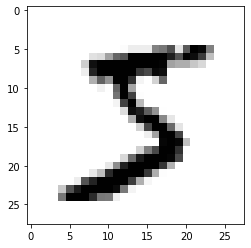

In [4]:
x, y = train_dataset[0]
print("Shape of x: ", x.shape)
print("Label: ", y)

plt.imshow(x.numpy().squeeze(), cmap='gray_r');

Let's look at a bunch of samples!

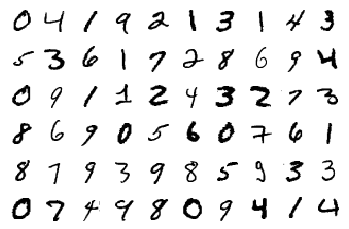

In [5]:
figure = plt.figure()
num_of_images = 60
for i in range(1, num_of_images + 1):
    x, y = train_dataset[i]
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(x.numpy().squeeze(), cmap='gray_r')

### Model
You are responsible for defining the model f(x) = y, where x is an image and y is the digit found in the image. We provide one way to do this, but you will need to explore different model architectures and training strategies to get sufficient performance: 

The shape of any image x is 28x28. We can reshape the image so it is instead a vector of length 28*28 = 784. Then, we can use the methods described in the introduction notebook to map a 784-dimensional vector to a 10-dimensional vector of probabilities. The digit in the image will then correspond to the index of the highest probability entry in the predicted 10-dimensional vector.

In [13]:
model = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
            torch.nn.LogSoftmax(dim=1)
        )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Unlike regression, where the predicted output y is a scalar in $\mathbb{R}$, in classification the model outputs logits or scores, one for each class. In our problem, there are 10 classes so the output of f(x) is a 10-dimensional vector of scores. 

In order to convert these scores to probabilities, we can simply normalize. Typically, the softmax operation is used to compute probabilties from logits or scores. After computing the prediction y = f(x), which is a 10-dimensional, we can compute the probability vector p:

$$p_i = \frac{e^{y_i}}{\sum_{j=1}^{10} e^{y_j}}, i=1,\ldots, 10, \text{ or } p=softmax(y)$$

In [14]:
def probabilties_from_scores(y):
    f = torch.nn.Softmax(dim=1)
    p = f(y)
    return p

### Loss

For $K$ classes, our labels y in the dataset will take on an integer value between [0,K]. We must convert these values to one-hot representations. For example, when $K=3$, y = 1 as a one-hot vector would be $[1,0,0]$ to represent the first class. If the model predicts a probability $p\in\mathbb{R}^K$ for this training instance, the loss function is

$$L = - \sum_{i=1}^K y_i \log p_i$$

Therefore, in the example where y = 1, L = - probability of the first entry since the one-hot vector is [1, 0, 0]. The loss function motivates assigning high probability to true classes and low probability otherwise.

In [15]:
def loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,) 
    f = torch.nn.CrossEntropyLoss()
    return f(y_hat, y)

### Optimization
Now we perform stochastic gradient descent on the model. We can first try to evaluate the model's initial performance on the testing dataset as a comparison.

In [16]:
def evaluate(dataloader, model, log=False):
    correct_count, total_count = 0, 0
    for images_batch, labels_batch in dataloader:
        images = images_batch.reshape(images_batch.shape[0], 28*28)
        scores = model(images)
        probabilities = probabilties_from_scores(scores)
        
        pred_label = probabilities.max(1, keepdim=True)[1]
        correct_count += pred_label.eq(labels_batch.view_as(pred_label)).sum().item()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count/total_count))
    
    return (correct_count/total_count)

In [17]:
result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.1225


#### Training Loop
Optimize the model to improve the prediction accuracy.

In [18]:
epochs = 15
for epoch in range(epochs):
    running_loss = 0
    for images_batch, labels_batch in train_dataloader:
        images_batch = images_batch.reshape(images_batch.shape[0], 28*28)   # Flatten MNIST images into a 784 long vector
        
        # forward pass
        y_hat = model(images_batch)
        y = labels_batch
        L = loss(y_hat, y)
        
        # backward pass
        optimizer.zero_grad()
        L.backward()
        
        # update parameters
        optimizer.step()
        
        running_loss += L.item()
        
    training_loss = running_loss/len(train_dataloader)
    train_accuracy = evaluate(train_dataloader, model)
    test_accuracy = evaluate(test_dataloader, model)                                  
    
    if epoch % 1 == 0:
        print("Epoch {} - Training loss: {}  Train Accuracy: {}  Test Accuracy: {}".format(epoch, training_loss, train_accuracy, test_accuracy))

Epoch 0 - Training loss: 0.39369237047236866  Train Accuracy: 0.9364833333333333  Test Accuracy: 0.9353
Epoch 1 - Training loss: 0.18769478843386558  Train Accuracy: 0.9604333333333334  Test Accuracy: 0.9576
Epoch 2 - Training loss: 0.13589882795939218  Train Accuracy: 0.9602166666666667  Test Accuracy: 0.9574
Epoch 3 - Training loss: 0.10858566562698753  Train Accuracy: 0.9736666666666667  Test Accuracy: 0.966
Epoch 4 - Training loss: 0.09143475009831412  Train Accuracy: 0.9786833333333333  Test Accuracy: 0.9706
Epoch 5 - Training loss: 0.08018673656072452  Train Accuracy: 0.97795  Test Accuracy: 0.9715
Epoch 6 - Training loss: 0.06951374651480423  Train Accuracy: 0.9806833333333334  Test Accuracy: 0.9703
Epoch 7 - Training loss: 0.06316657161721384  Train Accuracy: 0.9813166666666666  Test Accuracy: 0.9724
Epoch 8 - Training loss: 0.059287546306296485  Train Accuracy: 0.9832  Test Accuracy: 0.97
Epoch 9 - Training loss: 0.05193096383992058  Train Accuracy: 0.98445  Test Accuracy: 0.9

#### Evaluation 
Test the model's accuracy on the unseen test dataset.

In [12]:
result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.922


See that the model's performance improves from 10% accuracy to about 92%. For this simple task, getting an accuracy of 95% is not quite impressive. Try to tweak the parameters and neural network architecture to get better predictions! You should be able to get >= 98% test accuracy.